In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Boilerplate MLP

In [6]:
# Build Dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revistited

n_emb = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neirons in the hidden layer of the MLP\

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g)
b1 = torch.randn((n_hidden),                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn((vocab_size),                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total params
for p in parameters:
    p.requires_grad = True

11897


In [11]:
# Same optimization as MLP 1
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # Embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) # Concat the vectors
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.8240
  20000/ 200000: 2.5163
  30000/ 200000: 2.8836
  40000/ 200000: 2.0655
  50000/ 200000: 2.4969
  60000/ 200000: 2.4992
  70000/ 200000: 2.0261
  80000/ 200000: 2.4461
  90000/ 200000: 2.2756
 100000/ 200000: 2.0263
 110000/ 200000: 2.3349
 120000/ 200000: 1.8987
 130000/ 200000: 2.3830
 140000/ 200000: 2.1785
 150000/ 200000: 2.1847
 160000/ 200000: 2.0797
 170000/ 200000: 1.8553
 180000/ 200000: 1.9629
 190000/ 200000: 1.8522


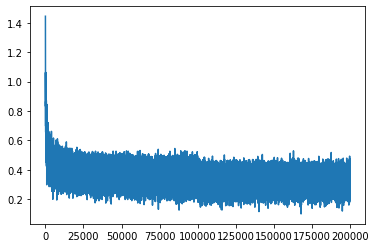

In [13]:
plt.plot(lossi);

`@torch.no_grad()` Basically tells the function beneath it that any tensors will not need to do gradient tracking. It improves efficiency

In [14]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.12178111076355
val 2.1625618934631348


In [22]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khirmrex.
taty.
skanden.
jazonel.
den.
arci.
aqui.
ner.
kentzieiivia.
legy.
dham.
jorn.
quintis.
lilea.
jadii.
waythoniearynix.
kaeliigh.
boe.
